In [4]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # For saving/loading models
import sqlite3

# --- Machine Learning Imports ---
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import r2_score, mean_squared_error

# For nicer plots (optional)
if 'seaborn-whitegrid' in plt.style.available:
    plt.style.use('seaborn-whitegrid')
elif 'seaborn-v0_8-whitegrid' in plt.style.available:
    plt.style.use('seaborn-v0_8-whitegrid')
else:
    plt.style.use('seaborn')
sns.set_palette("husl", 8)

# --- Database Connection & Load Materials Data ---
project_root = os.getcwd() # Assuming notebook is at project root
db_file_name = "perovskite_platform.sqlite"
db_path = os.path.join(project_root, "data", "processed", db_file_name)

conn = None
try:
    conn = sqlite3.connect(db_path) # Make sure sqlite3 is imported if not done via another cell
    print(f"Successfully connected to SQLite database: {db_path}")
except sqlite3.Error as e: # Use specific sqlite3.Error
    print(f"Error connecting to database {db_path}: {e}")
    conn = None 

materials_df = pd.DataFrame()
if conn:
    try:
        materials_df = pd.read_sql_query("SELECT * FROM Materials ORDER BY material_x_value", conn)
        print("Materials table loaded for modeling.")
        # Ensure boolean/integer columns that might have been loaded as objects are numeric if needed
        # (Not critical for the chosen targets, but good practice)
    except Exception as e:
        print(f"Error loading Materials table: {e}")
else:
    print("Database connection not established. Cannot load Materials table for modeling.")

# Define directory for saving models
MODELS_DIR = os.path.join(project_root, 'src', 'surrogate_models_trained') # Changed from 'src/surrogate_models' which holds .py
os.makedirs(MODELS_DIR, exist_ok=True)

# ORDERED_X_VALUES for plotting reference (though X_train comes from df)
ORDERED_X_VALUES = sorted([0,1,2,3,4,5,6])

Successfully connected to SQLite database: c:\Users\E1009134\OneDrive - ams OSRAM\Portfolio_ San\Cs2NaTlBr6-xClx\data\processed\perovskite_platform.sqlite
Materials table loaded for modeling.


direct_gap_ev

In [6]:
target_property_name = 'direct_gap_ev'
print(f"\n--- Preparing Data for Modeling: {target_property_name} ---")

X_train_property = None
y_train_property = None

if not materials_df.empty and target_property_name in materials_df.columns:
    modeling_df_property = materials_df[['material_x_value', target_property_name]].copy().dropna(subset=[target_property_name])
    
    if len(modeling_df_property) >= 3: # Need a few points for modeling
        X_train_property = modeling_df_property[['material_x_value']] 
        y_train_property = modeling_df_property[target_property_name]
        print(f"Using {len(X_train_property)} data points for '{target_property_name}'.")
        print("X_train values:\n", X_train_property['material_x_value'].values)
        print("y_train values:\n", y_train_property.values)
    else:
        print(f"ERROR: Not enough valid data points for '{target_property_name}' to build a model.")
else:
    print(f"'{target_property_name}' column not found in materials_df or materials_df is empty.")


--- Preparing Data for Modeling: direct_gap_ev ---
Using 6 data points for 'direct_gap_ev'.
X_train values:
 [0 1 2 3 4 6]
y_train values:
 [0.7999 0.8346 0.9414 1.0391 1.2643 1.7502]



--- Polynomial Regression for: direct_gap_ev ---
  Degree 3 - R² (train): 0.9983, MSE (train): 0.0002


c:\Users\E1009134\OneDrive - ams OSRAM\Portfolio_ San\Cs2NaTlBr6-xClx\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


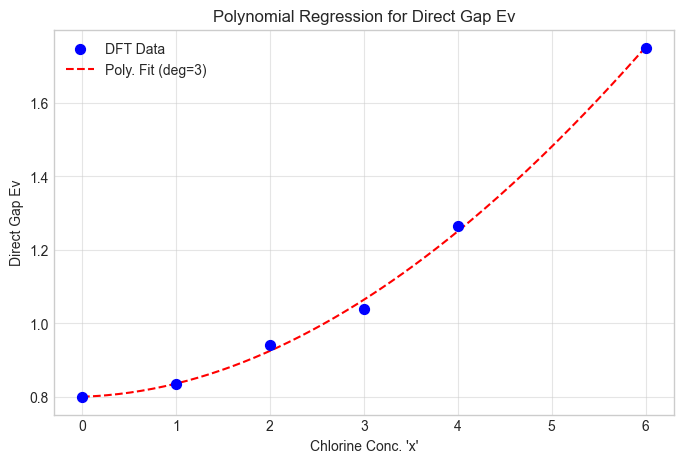

  Saved Polynomial model to c:\Users\E1009134\OneDrive - ams OSRAM\Portfolio_ San\Cs2NaTlBr6-xClx\src\surrogate_models_trained\poly_model_direct_gap_ev.pkl


In [7]:
if X_train_property is not None and y_train_property is not None:
    print(f"\n--- Polynomial Regression for: {target_property_name} ---")
    poly_degree = 3 # Adjust if needed (2 or 3 often good for 7 points)
    
    poly_model = make_pipeline(
        PolynomialFeatures(degree=poly_degree, include_bias=False), 
        LinearRegression()
    )
    poly_model.fit(X_train_property, y_train_property)

    y_pred_poly_train = poly_model.predict(X_train_property)
    r2_poly = r2_score(y_train_property, y_pred_poly_train)
    mse_poly = mean_squared_error(y_train_property, y_pred_poly_train)
    print(f"  Degree {poly_degree} - R² (train): {r2_poly:.4f}, MSE (train): {mse_poly:.4f}")

    plt.figure(figsize=(8, 5))
    plt.scatter(X_train_property['material_x_value'], y_train_property, color='blue', label='DFT Data', zorder=5, s=50)
    x_plot = np.linspace(X_train_property['material_x_value'].min(), X_train_property['material_x_value'].max(), 200).reshape(-1, 1)
    y_plot_poly = poly_model.predict(x_plot)
    plt.plot(x_plot, y_plot_poly, color='red', linestyle='--', label=f'Poly. Fit (deg={poly_degree})')
    plt.xlabel("Chlorine Conc. 'x'")
    plt.ylabel(target_property_name.replace('_',' ').title())
    plt.title(f"Polynomial Regression for {target_property_name.replace('_',' ').title()}")
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.show()

    # Save the model
    model_poly_filename = os.path.join(MODELS_DIR, f'poly_model_{target_property_name}.pkl')
    joblib.dump(poly_model, model_poly_filename)
    print(f"  Saved Polynomial model to {model_poly_filename}")
else:
    print(f"Skipping Polynomial Regression for {target_property_name}: Training data not available.")


--- Gaussian Process Regression for: direct_gap_ev ---
  GPR - R² (train): 0.9984, MSE (train): 0.0002
  Learned GPR Kernel: 1.93**2 * RBF(length_scale=8.14) + WhiteKernel(noise_level=0.000408)


c:\Users\E1009134\OneDrive - ams OSRAM\Portfolio_ San\Cs2NaTlBr6-xClx\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


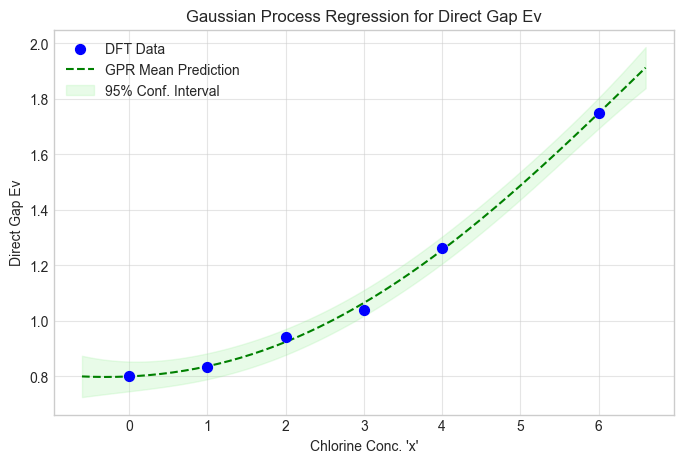

  Saved GPR model to c:\Users\E1009134\OneDrive - ams OSRAM\Portfolio_ San\Cs2NaTlBr6-xClx\src\surrogate_models_trained\gpr_model_direct_gap_ev.pkl


In [8]:
if X_train_property is not None and y_train_property is not None:
    print(f"\n--- Gaussian Process Regression for: {target_property_name} ---")
    
    # Kernel: C = constant scaling, RBF = radial basis function (smoothness)
    # WhiteKernel handles noise in the observations.
    # length_scale defines how "wiggly" the RBF function can be.
    # noise_level_bounds are important to prevent overfitting if data is noisy (less of an issue with DFT data).
    kernel_gpr = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) \
             + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1)) # Small initial noise
    
    gpr_model = GaussianProcessRegressor(
        kernel=kernel_gpr, 
        n_restarts_optimizer=20, # Helps find better kernel parameters
        alpha=1e-7,              # Small value for numerical stability, effectively assuming low noise in y
        random_state=42
    )
    gpr_model.fit(X_train_property, y_train_property)

    y_pred_gpr_train, y_std_gpr_train = gpr_model.predict(X_train_property, return_std=True)
    r2_gpr = r2_score(y_train_property, y_pred_gpr_train)
    mse_gpr = mean_squared_error(y_train_property, y_pred_gpr_train)
    print(f"  GPR - R² (train): {r2_gpr:.4f}, MSE (train): {mse_gpr:.4f}")
    print(f"  Learned GPR Kernel: {gpr_model.kernel_}")

    plt.figure(figsize=(8, 5))
    plt.scatter(X_train_property['material_x_value'], y_train_property, color='blue', label='DFT Data', zorder=5, s=50)
    
    # Extend plotting range slightly to see extrapolation behavior and uncertainty growth
    x_plot_min = X_train_property['material_x_value'].min()
    x_plot_max = X_train_property['material_x_value'].max()
    x_plot_range_extension = (x_plot_max - x_plot_min) * 0.1 # 10% extension
    x_plot = np.linspace(x_plot_min - x_plot_range_extension, x_plot_max + x_plot_range_extension, 200).reshape(-1, 1)
    
    y_plot_gpr, y_plot_std_gpr = gpr_model.predict(x_plot, return_std=True)
    
    plt.plot(x_plot.ravel(), y_plot_gpr, color='green', linestyle='--', label='GPR Mean Prediction')
    plt.fill_between(x_plot.ravel(), 
                     y_plot_gpr - 1.96 * y_plot_std_gpr, # 95% confidence interval
                     y_plot_gpr + 1.96 * y_plot_std_gpr, 
                     alpha=0.2, color='lightgreen', label='95% Conf. Interval')
    
    plt.xlabel("Chlorine Conc. 'x'")
    plt.ylabel(target_property_name.replace('_',' ').title())
    plt.title(f"Gaussian Process Regression for {target_property_name.replace('_',' ').title()}")
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.show()

    # Save the model
    model_gpr_filename = os.path.join(MODELS_DIR, f'gpr_model_{target_property_name}.pkl')
    joblib.dump(gpr_model, model_gpr_filename)
    print(f"  Saved GPR model to {model_gpr_filename}")
else:
    print(f"Skipping GPR for {target_property_name}: Training data not available.")

bulk_modulus_k_hill_gpa

In [ ]:
target_property_name = 'bulk_modulus_k_hill_gpa' # << CHANGE THIS
print(f"\n--- Preparing Data for Modeling: {target_property_name} ---")
# ... (rest of the data prep code from P1.1, it will use the new target_property_name) ...
if not materials_df.empty and target_property_name in materials_df.columns:
    modeling_df_property = materials_df[['material_x_value', target_property_name]].copy().dropna(subset=[target_property_name])
    if len(modeling_df_property) >= 3:
        X_train_property = modeling_df_property[['material_x_value']] 
        y_train_property = modeling_df_property[target_property_name]
        print(f"Using {len(X_train_property)} data points for '{target_property_name}'.")
    else:
        print(f"ERROR: Not enough data for '{target_property_name}'."); X_train_property=None; y_train_property=None
else:
    print(f"'{target_property_name}' not found or materials_df empty."); X_train_property=None; y_train_property=None


--- Preparing Data for Modeling: bulk_modulus_k_hill_gpa ---
Using 7 data points for 'bulk_modulus_k_hill_gpa'.



--- Polynomial Regression for: bulk_modulus_k_hill_gpa ---
  Degree 3 - R² (train): 0.9964, MSE (train): 0.0057


c:\Users\E1009134\OneDrive - ams OSRAM\Portfolio_ San\Cs2NaTlBr6-xClx\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


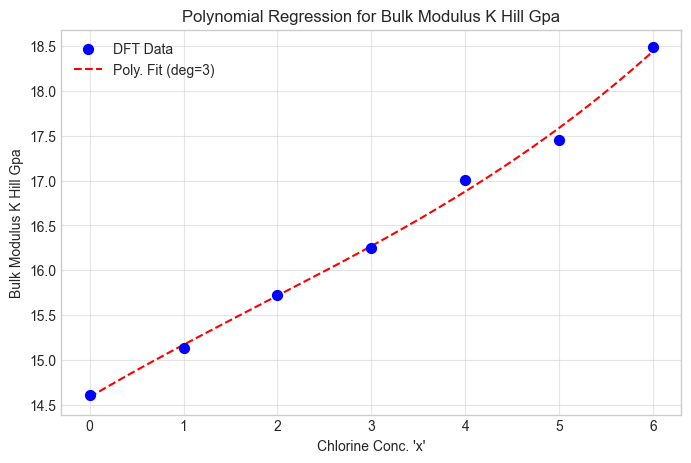

  Saved Polynomial model to c:\Users\E1009134\OneDrive - ams OSRAM\Portfolio_ San\Cs2NaTlBr6-xClx\src\surrogate_models_trained\poly_model_bulk_modulus_k_hill_gpa.pkl


In [10]:
if X_train_property is not None and y_train_property is not None:
    print(f"\n--- Polynomial Regression for: {target_property_name} ---")
    poly_degree = 3 # Adjust if needed (2 or 3 often good for 7 points)
    
    poly_model = make_pipeline(
        PolynomialFeatures(degree=poly_degree, include_bias=False), 
        LinearRegression()
    )
    poly_model.fit(X_train_property, y_train_property)

    y_pred_poly_train = poly_model.predict(X_train_property)
    r2_poly = r2_score(y_train_property, y_pred_poly_train)
    mse_poly = mean_squared_error(y_train_property, y_pred_poly_train)
    print(f"  Degree {poly_degree} - R² (train): {r2_poly:.4f}, MSE (train): {mse_poly:.4f}")

    plt.figure(figsize=(8, 5))
    plt.scatter(X_train_property['material_x_value'], y_train_property, color='blue', label='DFT Data', zorder=5, s=50)
    x_plot = np.linspace(X_train_property['material_x_value'].min(), X_train_property['material_x_value'].max(), 200).reshape(-1, 1)
    y_plot_poly = poly_model.predict(x_plot)
    plt.plot(x_plot, y_plot_poly, color='red', linestyle='--', label=f'Poly. Fit (deg={poly_degree})')
    plt.xlabel("Chlorine Conc. 'x'")
    plt.ylabel(target_property_name.replace('_',' ').title())
    plt.title(f"Polynomial Regression for {target_property_name.replace('_',' ').title()}")
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.show()

    # Save the model
    model_poly_filename = os.path.join(MODELS_DIR, f'poly_model_{target_property_name}.pkl')
    joblib.dump(poly_model, model_poly_filename)
    print(f"  Saved Polynomial model to {model_poly_filename}")
else:
    print(f"Skipping Polynomial Regression for {target_property_name}: Training data not available.")


--- Gaussian Process Regression for: bulk_modulus_k_hill_gpa ---
  GPR - R² (train): 0.9943, MSE (train): 0.0090
  Learned GPR Kernel: 22.8**2 * RBF(length_scale=27.3) + WhiteKernel(noise_level=0.0148)


c:\Users\E1009134\OneDrive - ams OSRAM\Portfolio_ San\Cs2NaTlBr6-xClx\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


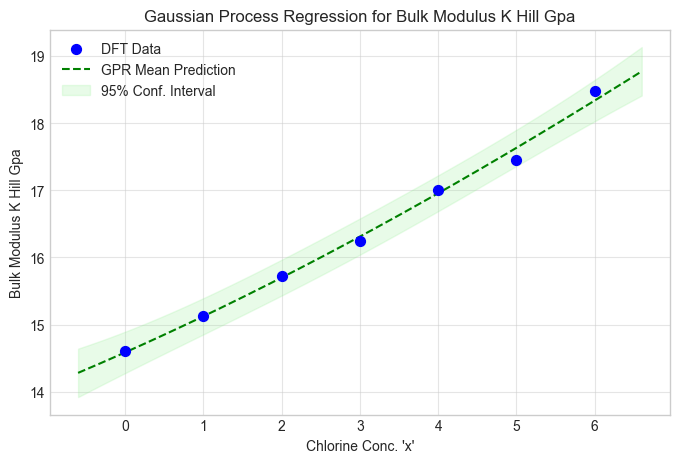

  Saved GPR model to c:\Users\E1009134\OneDrive - ams OSRAM\Portfolio_ San\Cs2NaTlBr6-xClx\src\surrogate_models_trained\gpr_model_bulk_modulus_k_hill_gpa.pkl


In [12]:
if X_train_property is not None and y_train_property is not None:
    print(f"\n--- Gaussian Process Regression for: {target_property_name} ---")
    
    # Kernel: C = constant scaling, RBF = radial basis function (smoothness)
    # WhiteKernel handles noise in the observations.
    # length_scale defines how "wiggly" the RBF function can be.
    # noise_level_bounds are important to prevent overfitting if data is noisy (less of an issue with DFT data).
    kernel_gpr = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) \
             + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1)) # Small initial noise
    
    gpr_model = GaussianProcessRegressor(
        kernel=kernel_gpr, 
        n_restarts_optimizer=20, # Helps find better kernel parameters
        alpha=1e-7,              # Small value for numerical stability, effectively assuming low noise in y
        random_state=42
    )
    gpr_model.fit(X_train_property, y_train_property)

    y_pred_gpr_train, y_std_gpr_train = gpr_model.predict(X_train_property, return_std=True)
    r2_gpr = r2_score(y_train_property, y_pred_gpr_train)
    mse_gpr = mean_squared_error(y_train_property, y_pred_gpr_train)
    print(f"  GPR - R² (train): {r2_gpr:.4f}, MSE (train): {mse_gpr:.4f}")
    print(f"  Learned GPR Kernel: {gpr_model.kernel_}")

    plt.figure(figsize=(8, 5))
    plt.scatter(X_train_property['material_x_value'], y_train_property, color='blue', label='DFT Data', zorder=5, s=50)
    
    # Extend plotting range slightly to see extrapolation behavior and uncertainty growth
    x_plot_min = X_train_property['material_x_value'].min()
    x_plot_max = X_train_property['material_x_value'].max()
    x_plot_range_extension = (x_plot_max - x_plot_min) * 0.1 # 10% extension
    x_plot = np.linspace(x_plot_min - x_plot_range_extension, x_plot_max + x_plot_range_extension, 200).reshape(-1, 1)
    
    y_plot_gpr, y_plot_std_gpr = gpr_model.predict(x_plot, return_std=True)
    
    plt.plot(x_plot.ravel(), y_plot_gpr, color='green', linestyle='--', label='GPR Mean Prediction')
    plt.fill_between(x_plot.ravel(), 
                     y_plot_gpr - 1.96 * y_plot_std_gpr, # 95% confidence interval
                     y_plot_gpr + 1.96 * y_plot_std_gpr, 
                     alpha=0.2, color='lightgreen', label='95% Conf. Interval')
    
    plt.xlabel("Chlorine Conc. 'x'")
    plt.ylabel(target_property_name.replace('_',' ').title())
    plt.title(f"Gaussian Process Regression for {target_property_name.replace('_',' ').title()}")
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.show()

    # Save the model
    model_gpr_filename = os.path.join(MODELS_DIR, f'gpr_model_{target_property_name}.pkl')
    joblib.dump(gpr_model, model_gpr_filename)
    print(f"  Saved GPR model to {model_gpr_filename}")
else:
    print(f"Skipping GPR for {target_property_name}: Training data not available.")

debye_temperature_k

In [13]:
target_property_name = 'debye_temperature_k' # << CHANGE THIS
print(f"\n--- Preparing Data for Modeling: {target_property_name} ---")
# ... (rest of the data prep code from P1.1) ...
if not materials_df.empty and target_property_name in materials_df.columns:
    modeling_df_property = materials_df[['material_x_value', target_property_name]].copy().dropna(subset=[target_property_name])
    if len(modeling_df_property) >= 3:
        X_train_property = modeling_df_property[['material_x_value']] 
        y_train_property = modeling_df_property[target_property_name]
        print(f"Using {len(X_train_property)} data points for '{target_property_name}'.")
    else:
        print(f"ERROR: Not enough data for '{target_property_name}'."); X_train_property=None; y_train_property=None
else:
    print(f"'{target_property_name}' not found or materials_df empty."); X_train_property=None; y_train_property=None


--- Preparing Data for Modeling: debye_temperature_k ---
Using 7 data points for 'debye_temperature_k'.



--- Polynomial Regression for: debye_temperature_k ---
  Degree 3 - R² (train): 0.7843, MSE (train): 112.7220


c:\Users\E1009134\OneDrive - ams OSRAM\Portfolio_ San\Cs2NaTlBr6-xClx\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


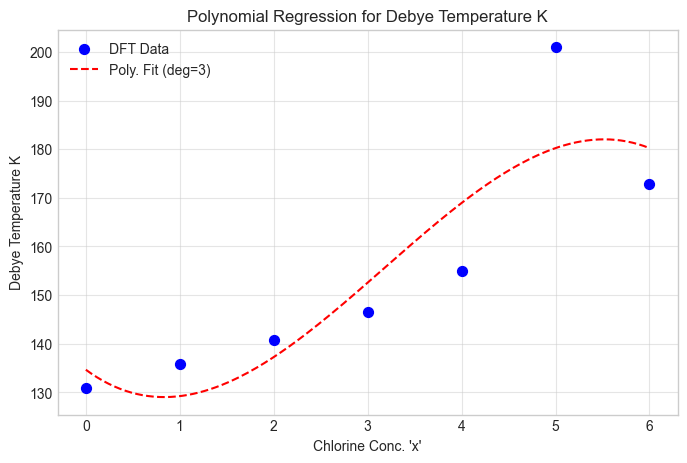

  Saved Polynomial model to c:\Users\E1009134\OneDrive - ams OSRAM\Portfolio_ San\Cs2NaTlBr6-xClx\src\surrogate_models_trained\poly_model_debye_temperature_k.pkl


In [16]:
if X_train_property is not None and y_train_property is not None:
    print(f"\n--- Polynomial Regression for: {target_property_name} ---")
    poly_degree = 3 # Adjust if needed (2 or 3 often good for 7 points)
    
    poly_model = make_pipeline(
        PolynomialFeatures(degree=poly_degree, include_bias=False), 
        LinearRegression()
    )
    poly_model.fit(X_train_property, y_train_property)

    y_pred_poly_train = poly_model.predict(X_train_property)
    r2_poly = r2_score(y_train_property, y_pred_poly_train)
    mse_poly = mean_squared_error(y_train_property, y_pred_poly_train)
    print(f"  Degree {poly_degree} - R² (train): {r2_poly:.4f}, MSE (train): {mse_poly:.4f}")

    plt.figure(figsize=(8, 5))
    plt.scatter(X_train_property['material_x_value'], y_train_property, color='blue', label='DFT Data', zorder=5, s=50)
    x_plot = np.linspace(X_train_property['material_x_value'].min(), X_train_property['material_x_value'].max(), 200).reshape(-1, 1)
    y_plot_poly = poly_model.predict(x_plot)
    plt.plot(x_plot, y_plot_poly, color='red', linestyle='--', label=f'Poly. Fit (deg={poly_degree})')
    plt.xlabel("Chlorine Conc. 'x'")
    plt.ylabel(target_property_name.replace('_',' ').title())
    plt.title(f"Polynomial Regression for {target_property_name.replace('_',' ').title()}")
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.show()

    # Save the model
    model_poly_filename = os.path.join(MODELS_DIR, f'poly_model_{target_property_name}.pkl')
    joblib.dump(poly_model, model_poly_filename)
    print(f"  Saved Polynomial model to {model_poly_filename}")
else:
    print(f"Skipping Polynomial Regression for {target_property_name}: Training data not available.")


--- Gaussian Process Regression for: debye_temperature_k ---
  GPR - R² (train): 0.9877, MSE (train): 6.4403
  Learned GPR Kernel: 31.6**2 * RBF(length_scale=1.41) + WhiteKernel(noise_level=10)


c:\Users\E1009134\OneDrive - ams OSRAM\Portfolio_ San\Cs2NaTlBr6-xClx\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\E1009134\OneDrive - ams OSRAM\Portfolio_ San\Cs2NaTlBr6-xClx\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\E1009134\OneDrive - ams OSRAM\Portfolio_ San\Cs2NaTlBr6-xClx\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


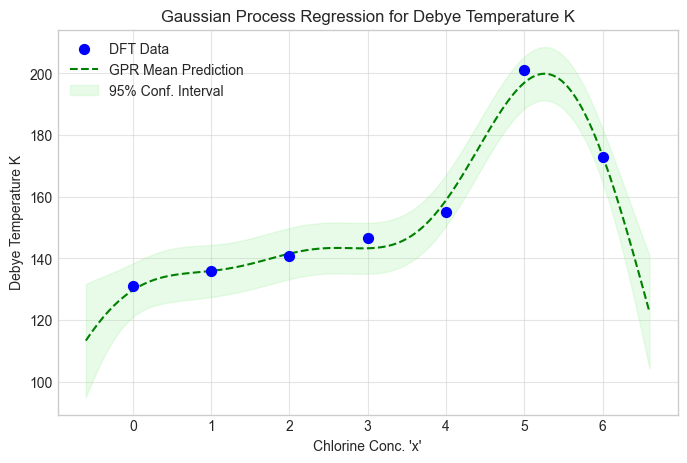

  Saved GPR model to c:\Users\E1009134\OneDrive - ams OSRAM\Portfolio_ San\Cs2NaTlBr6-xClx\src\surrogate_models_trained\gpr_model_debye_temperature_k.pkl


In [17]:
if X_train_property is not None and y_train_property is not None:
    print(f"\n--- Gaussian Process Regression for: {target_property_name} ---")
    
    # Kernel: C = constant scaling, RBF = radial basis function (smoothness)
    # WhiteKernel handles noise in the observations.
    # length_scale defines how "wiggly" the RBF function can be.
    # noise_level_bounds are important to prevent overfitting if data is noisy (less of an issue with DFT data).
    kernel_gpr = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) \
             + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1)) # Small initial noise
    
    gpr_model = GaussianProcessRegressor(
        kernel=kernel_gpr, 
        n_restarts_optimizer=20, # Helps find better kernel parameters
        alpha=1e-7,              # Small value for numerical stability, effectively assuming low noise in y
        random_state=42
    )
    gpr_model.fit(X_train_property, y_train_property)

    y_pred_gpr_train, y_std_gpr_train = gpr_model.predict(X_train_property, return_std=True)
    r2_gpr = r2_score(y_train_property, y_pred_gpr_train)
    mse_gpr = mean_squared_error(y_train_property, y_pred_gpr_train)
    print(f"  GPR - R² (train): {r2_gpr:.4f}, MSE (train): {mse_gpr:.4f}")
    print(f"  Learned GPR Kernel: {gpr_model.kernel_}")

    plt.figure(figsize=(8, 5))
    plt.scatter(X_train_property['material_x_value'], y_train_property, color='blue', label='DFT Data', zorder=5, s=50)
    
    # Extend plotting range slightly to see extrapolation behavior and uncertainty growth
    x_plot_min = X_train_property['material_x_value'].min()
    x_plot_max = X_train_property['material_x_value'].max()
    x_plot_range_extension = (x_plot_max - x_plot_min) * 0.1 # 10% extension
    x_plot = np.linspace(x_plot_min - x_plot_range_extension, x_plot_max + x_plot_range_extension, 200).reshape(-1, 1)
    
    y_plot_gpr, y_plot_std_gpr = gpr_model.predict(x_plot, return_std=True)
    
    plt.plot(x_plot.ravel(), y_plot_gpr, color='green', linestyle='--', label='GPR Mean Prediction')
    plt.fill_between(x_plot.ravel(), 
                     y_plot_gpr - 1.96 * y_plot_std_gpr, # 95% confidence interval
                     y_plot_gpr + 1.96 * y_plot_std_gpr, 
                     alpha=0.2, color='lightgreen', label='95% Conf. Interval')
    
    plt.xlabel("Chlorine Conc. 'x'")
    plt.ylabel(target_property_name.replace('_',' ').title())
    plt.title(f"Gaussian Process Regression for {target_property_name.replace('_',' ').title()}")
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.show()

    # Save the model
    model_gpr_filename = os.path.join(MODELS_DIR, f'gpr_model_{target_property_name}.pkl')
    joblib.dump(gpr_model, model_gpr_filename)
    print(f"  Saved GPR model to {model_gpr_filename}")
else:
    print(f"Skipping GPR for {target_property_name}: Training data not available.")